# Set up

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scatter_plot_matrix as spm
import matplotlib.pylab as pylab

from statsmodels.stats.weightstats import DescrStatsW
from scipy.interpolate import CubicSpline

%matplotlib inline

In [2]:
sns.set_style("ticks",
             rc = {'axes.grid' : False,
                  'grid.linestyle' : 'dashed',
                  "xtick.direction": "in","ytick.direction": "in"})

sns.set_context('paper', font_scale=1.7)
sns.set_palette("tab10")

pylab.rcParams['xtick.major.pad']='6'

sns.set_palette("Set1")

# Reading and preparing data

In [7]:
def prepare_df(filename, pars, lcdm_defaults, filefolder='./output'):
    """Returns df and weights from filename and desired parameters"""
    df_full = pd.read_pickle('{}/{}.pkl'.format(filefolder, filename))
    print('There are {}/{} NaN values in {}.'.format(df_full['lp'].isna().sum(),
                                                     len(df_full),
                                                     filename))
    df_full = df_full.dropna()
    if filename == 'base_omegak_plikHM_TTTEEE_lowTEB_lp':
        idx_drop = df_full.index[df_full.lp < 130]
        print("Dropping {} of  {}.".format(idx_drop, filename))
        df_full.drop(index=idx_drop, inplace=True)
    # getting the right units for original chain
    if filename == 'base_plikHM_TTTEEE_lowTEB_lp':
        df_full.loc[:,'lp'] = df_full.loc[:,'lp']/(df_full.loc[:,'H0*']/100)
        df_full.loc[:,'cf_peak'] = df_full.loc[:,'cf_peak']/(df_full.loc[:,'H0*']/100)
        df_full.loc[:,'cf_dip'] = df_full.loc[:,'cf_dip']/(df_full.loc[:,'H0*']/100)
    ext_pars = list(lcdm_defaults.keys())
    for par in ext_pars:
        if par not in df_full.columns:
            df_full[par] = lcdm_defaults[par]
    weights = df_full.weight
    df = df_full[pars]
    df.index = np.arange(len(df))
    return df, weights

In [8]:
chain_name_lcdm = 'base_plikHM_TTTEEE_lowTEB_lp'
chain_name_w = 'base_w_plikHM_TTTEEE_lowTEB_lp'
chain_name_omk = 'base_omegak_plikHM_TTTEEE_lowTEB_lp'

lcdm_defaults =  {
    'w':-1,
    'omegak':0
}
ext_pars = list(lcdm_defaults.keys())

plot_folder_name = 'joint_plots'

In [9]:
params = ['cf_peak', 'cf_dip', 'lp','rdrag*', 'omegabh2', 'omegach2', 'H0*', 'tau', 'A*', 'ns', 'w', 'omegak']

In [10]:
df_lcdm, weights_lcdm = prepare_df(chain_name_lcdm, params, lcdm_defaults)
df_w, weights_w = prepare_df(chain_name_w, params, lcdm_defaults)
df_omk, weights_omk = prepare_df(chain_name_omk, params, lcdm_defaults)

There are 0/45979 NaN values in base_plikHM_TTTEEE_lowTEB_lp.
There are 3/38394 NaN values in base_w_plikHM_TTTEEE_lowTEB_lp.
There are 14/29244 NaN values in base_omegak_plikHM_TTTEEE_lowTEB_lp.
Dropping Int64Index([11635, 12312, 20166], dtype='int64') of  base_omegak_plikHM_TTTEEE_lowTEB_lp.


In [11]:
params_lp = ['cf_peak', 'cf_dip', 'lp','rdrag*']
params_clean = ['lp','omegabh2', 'omegach2', 'H0*', 'tau', 'A*', 'ns'] + ext_pars

In [12]:
#dftest = pd.read_pickle('./input/base_w_plikHM_TTTEEE_lowTEB.pkl')

# Functions and parameters for plotting

In [13]:
def plot_hist(ax, arr, weights, bins=50, color='black', ls='solid',
              label = None, stats_label=True, stats_text=False):
    stats = DescrStatsW(arr,weights=weights)
    mean = np.round(stats.mean,2)
    std = np.round(stats.std,2)
    precc = np.round(100*std/mean,2)

    
#     ax.set_title('$r$ = {} $\pm$ {}\n $\sigma/\mu$ = {}% '.format(mean,std,precc),
#          fontsize=15)
    if stats_label:
        if label is None:
            label = '$r$ = {} $\pm$ {}'.format(mean,std)
            ax.hist(arr, bins = bins, weights=weights, color=color,
                        histtype='step', density = True, lw = 3, label=label,
                   ls = ls)
        else:
            label = label+'\n$r$ = {} $\pm$ {}'.format(mean,std)
            ax.hist(arr, bins = bins, weights=weights, color=color,
                        histtype='step', density = True, lw = 3, label=label,
                   ls = ls)
    if stats_text:
        ax.hist(arr, bins = bins, weights=weights, color=color,
                histtype='step', density = True, lw = 3, label=label,
               ls = ls)
        ax.text(.98,.98,'$r$ = {} $\pm$ {}\n$\sigma/\mu$ = {}% '.format(mean,std,precc), 
                fontsize=15, 
                horizontalalignment='right', 
                verticalalignment='top',
                transform=ax.transAxes)
    ax.set_ylabel('Density')
    #ax.set_title(chain_name, fontsize=14)

In [14]:
def plot_matrix_grid(labels, size=18, label_rot = 45):
    g = spm.AxesGrid(len(labels), labels = labels, size=size,
                    legend_loc=[-2,-1])
    if label_rot:
        for i in range(g.nax):
            g.axes[-1,i].tick_params(axis='x', rotation=label_rot)
    return g

In [15]:
def plot_matrix(g, df, bins=30, weights=None, color='black', ls='solid', lw=2.5, label=None, smoothing_beam=1):
    g.add_hist(df, bins = bins, weights=weights, color=color, ls=ls, lw=lw)
    g.add_confidence_curves(df, fill=False, weights=weights, smoothing_beam=smoothing_beam,
                           colors=color, linestyles=ls, lw=lw)
    #g.add_hist2d(df, bins = bins, weights=weights)
    props = dict(boxstyle='square', facecolor='white', alpha=0.8,lw=lw, edgecolor='white')
    #g.add_corr_coef(df, weights, fontsize=18, bbox=props)
    if label:
        g.add_data_label(label, color, histtype='step', linestyle=ls, linewidth=lw)
    [ax.grid(False) for ax in g.axes.flat];
    
    return g

In [97]:
def jointplot(x,y,labels,bins=40):
    """Makes jointplot in Seaborn style from x and y distributions.
    Uses sns.JointGrid for the axes grid and spm._plot_confidence_levels_2d
    for the confidence curves.
    Returns axes object."""
    g = sns.JointGrid(x,y)
    g.plot_joint(plt.scatter, s=1, color='k', alpha=0.5,
            zorder=-3)
    g.plot_marginals(sns.distplot, kde=False, bins=bins,
                 hist_kws=dict(histtype='step', lw=2,
                              color='k',alpha=1))
    spm._plot_confidence_levels_2d(g.ax_joint,x,y, 
                               targets=[0.9545, 0.6827], 
                              colors='k', smoothing_beam=1)

    spm._plot_confidence_levels_2d(g.ax_joint,x,y, 
                               targets=[0.9545], 
                              fill=True,cmap='bwr', smoothing_beam=1,
                              zorder=-2)
    g.ax_joint.set_xlabel(labels[0])
    g.ax_joint.set_ylabel(labels[1])
    return g

# Paper Plots 

# Starting Plots

## Plotting - basics

In [123]:
plot_dict = dict(lcdm = dict(label=r'$\Lambda CDM$', color='black', ls='solid'),
                omk = dict(label=r'$\Lambda$CDM + $\Omega_k$', color='C0', ls='dashed'),
                w = dict(label=r'$\Lambda$CDM + $w$', color='C1', ls='dashdot'))

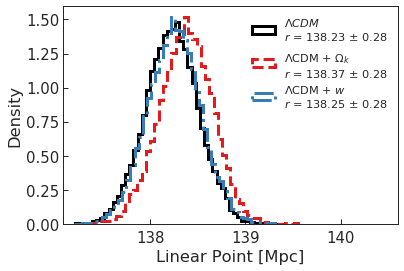

In [124]:
fig, ax = plt.subplots()

label, color, ls = list(plot_dict['lcdm'].values())
plot_hist(ax,df_lcdm.lp,weights_lcdm, label = label,
         color=color, ls=ls)

label, color, ls = list(plot_dict['omk'].values())
plot_hist(ax,df_omk.lp,weights_omk, label = label,
         color=color, ls=ls)

label, color, ls = list(plot_dict['w'].values())
plot_hist(ax,df_w.lp,weights_w, label = label,
         color=color, ls=ls)


ax.set_xlabel('Linear Point [Mpc]')
ax.legend(fontsize='x-small', frameon=False)
ax.set_xlim(right=140.6)
# plt.savefig('./Figures/{}/lp_dist_joint.pdf'.format(plot_folder_name), bbox_inches='tight',
#             transparent=True)

plt.show()

In [125]:
params_clean = ['lp', 'omegabh2', 'omegach2', 'H0*', 'tau', 'A*', 'ns', 'w', 'omegak']

plot_labels = [r'$r_{\rm lp}$ [Mpc]',
                r'$\Omega_b h^2$',
                r'$\Omega_c h^2$',
                r'$H_0$',
                r'$\tau$',
                r'$\ln (10^{10} A)$',
                r'$n_s$',
                r'$w$',
                r'$\Omega_k$']

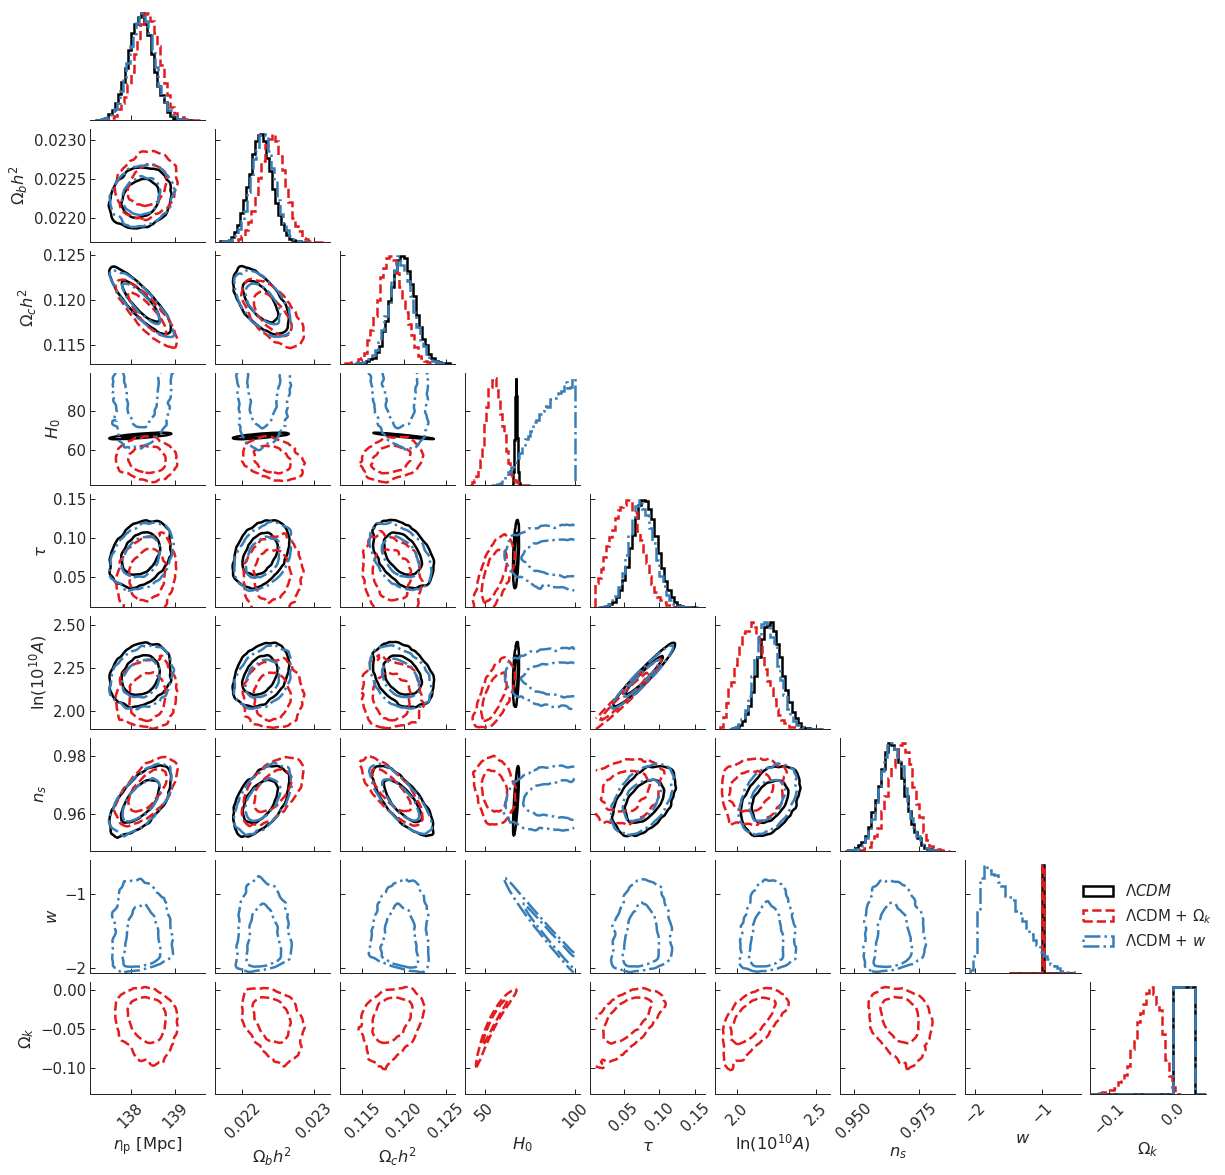

In [126]:
g = plot_matrix_grid(plot_labels, size=20)

label, color, ls = list(plot_dict['lcdm'].values())
g = plot_matrix(g, df_lcdm[params_clean],weights=weights_lcdm, 
                color=color, ls=ls, label=label)

label, color, ls = list(plot_dict['omk'].values())
g = plot_matrix(g, df_omk[params_clean],weights=weights_omk, 
                color=color, ls=ls, label=label)

label, color, ls = list(plot_dict['w'].values())
g = plot_matrix(g, df_w[params_clean],weights=weights_w, 
                color=color, ls=ls, label=label)

g.add_data_legend(frameon=False)

g.axes[-1,-1].set_xlim(-.13,.05)
g.label_ax.set_xlim(left=1e3)
# plt.savefig('./Figures/{}/lp_cosmo_matrix_joint.pdf'.format(plot_folder_name), bbox_inches='tight',
#             transparent=True)
plt.show()

In [127]:
labels_lp = [r'$r_{\rm peak}$ [Mpc]',
          r'$r_{\rm dip}$ [Mpc]',
          r'$r_{\rm lp}$ [Mpc]',
          r'$r_{\rm drag}$ [Mpc]']

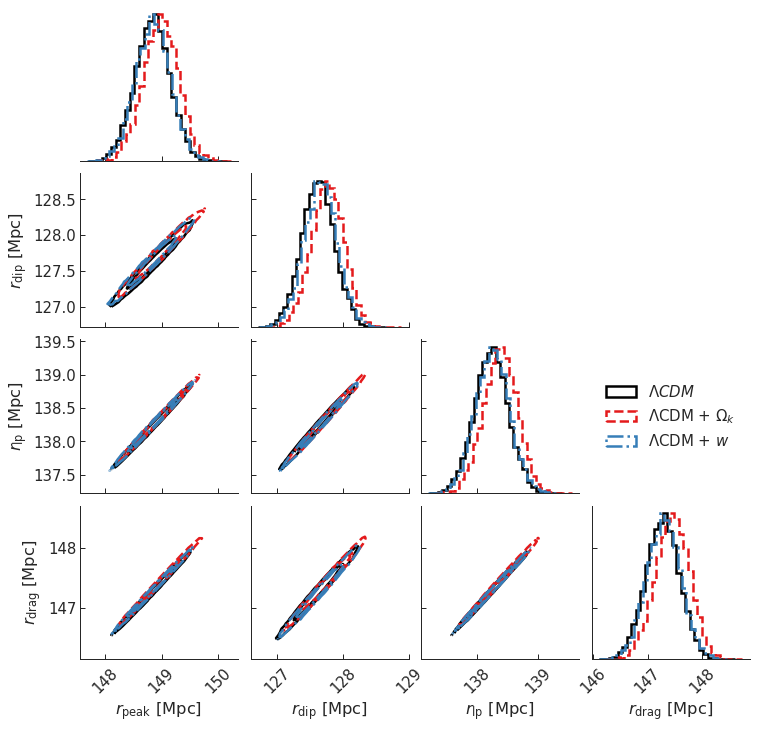

In [128]:
g = plot_matrix_grid(labels_lp, size=12)

label, color, ls = list(plot_dict['lcdm'].values())
g = plot_matrix(g, df_lcdm[params_lp],weights=weights_lcdm,
                color=color, ls=ls, label=label, smoothing_beam = 0)

label, color, ls = list(plot_dict['omk'].values())
g = plot_matrix(g, df_omk[params_lp],weights=weights_omk, 
                color=color, ls=ls, label=label, smoothing_beam = 0)

label, color, ls = list(plot_dict['w'].values())
g = plot_matrix(g, df_w[params_lp],weights=weights_w, 
               color=color, ls=ls, label=label, smoothing_beam = 0)

g.add_data_legend(frameon=False)
g.label_ax.set_xlim(left=1e3)
# plt.savefig('./Figures/{}/lp_cf_rdrag_matrix_joint.pdf'.format(plot_folder_name), bbox_inches='tight',
#             transparent=True)
plt.show()

# Auto distributions of lp, cf, rdrag

In [129]:
sns.set_context("poster", font_scale=0.9)

In [130]:
df_lcdm, weights_lcdm = prepare_df(chain_name_lcdm, params, lcdm_defaults)
df_w, weights_w = prepare_df(chain_name_w, params, lcdm_defaults)
df_omk, weights_omk = prepare_df(chain_name_omk, params, lcdm_defaults)

There are 0 NaN values in base_plikHM_TTTEEE_lowTEB_lp.
There are 3 NaN values in base_w_plikHM_TTTEEE_lowTEB_lp.
There are 14 NaN values in base_omegak_plikHM_TTTEEE_lowTEB_lp.
Dropping Int64Index([11635, 12312, 20166], dtype='int64') of  base_omegak_plikHM_TTTEEE_lowTEB_lp.


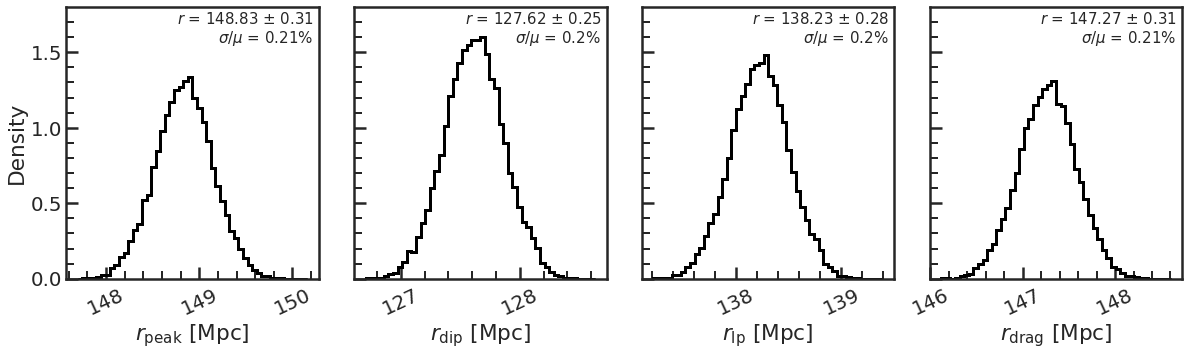

In [131]:
fig, ax = plt.subplots(1,4, figsize=(20,5), sharey=True)
df = df_lcdm.copy()
weights = weights_lcdm.copy()


for i in range(len(params_lp)):
    arr = df[params_lp[i]].values
    plot_hist(ax[i],arr,weights, bins = 50, stats_text=True)
    xticks = np.round(np.linspace(np.min(arr),np.max(arr),4),1)
    #ax[i].set_xticks(xticks)
    ax[i].set_xlabel(labels_lp[i])
    ax[i].tick_params('x', rotation = 25)
    ax[i].minorticks_on()
    if i > 0:
        #xticks = xticks[:]
        ax[i].set_ylabel("")

fig.subplots_adjust(wspace=0.14)
ax[0].set_ylim(0,1.8)
# plt.savefig('./Figures/{}/lp_cf_rdrag_dist.pdf'.format(plot_folder_name), bbox_inches='tight',
#             transparent=True)
plt.show()